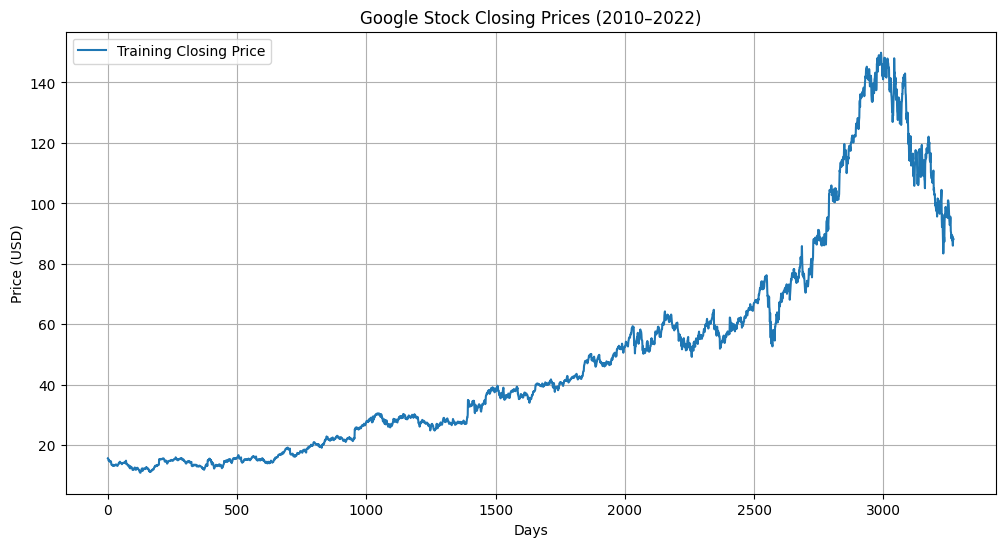

Epoch 1/20
101/101 [==============================] - 1s 7ms/step - loss: 0.0040
Epoch 2/20
101/101 [==============================] - 1s 7ms/step - loss: 2.3287e-04
Epoch 3/20
101/101 [==============================] - 1s 6ms/step - loss: 2.0133e-04
Epoch 4/20
101/101 [==============================] - 1s 6ms/step - loss: 2.1558e-04
Epoch 5/20
101/101 [==============================] - 1s 6ms/step - loss: 1.8201e-04
Epoch 6/20
101/101 [==============================] - 1s 7ms/step - loss: 1.5310e-04
Epoch 7/20
101/101 [==============================] - 1s 6ms/step - loss: 1.5723e-04
Epoch 8/20
101/101 [==============================] - 1s 6ms/step - loss: 1.5219e-04
Epoch 9/20
101/101 [==============================] - 1s 6ms/step - loss: 1.4461e-04
Epoch 10/20
101/101 [==============================] - 1s 6ms/step - loss: 1.3179e-04
Epoch 11/20
101/101 [==============================] - 1s 6ms/step - loss: 1.3405e-04
Epoch 12/20
101/101 [==============================] - 1s 6ms/step 

C:\Users\VARAD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


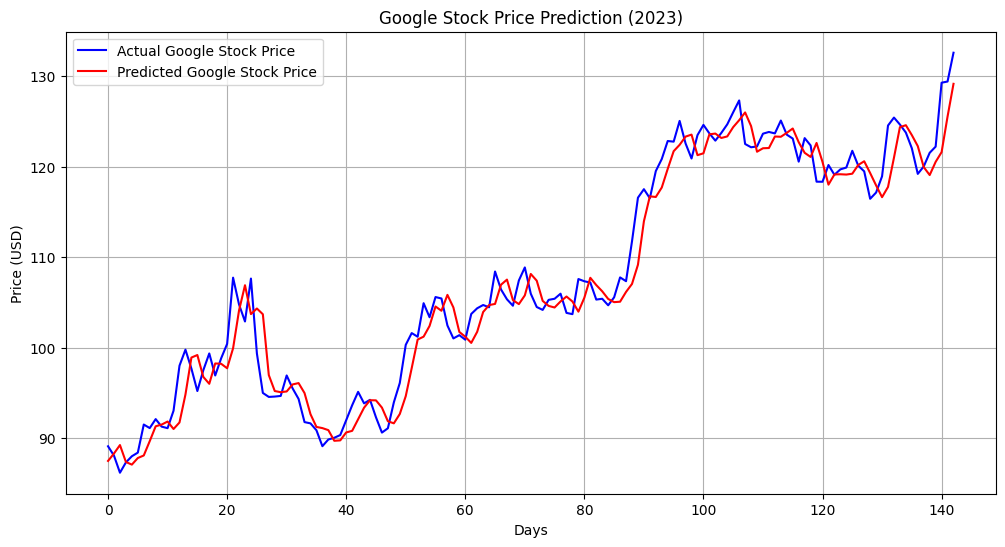

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_absolute_error

# Fix random seed for reproducibility
np.random.seed(42)

# === 1. Load Data ===
train_df = pd.read_csv('Google_Stock_Train (2010-2022).csv')
test_df = pd.read_csv('Google_Stock_Test (2023).csv')

# === 2. Visualize Training Data ===
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'], label='Training Closing Price')
plt.title('Google Stock Closing Prices (2010–2022)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# === 3. Preprocessing ===
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['Close']])

X_train = []
y_train = []

# Using 60 time steps (past 60 days) for prediction
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# === 4. Build RNN Model ===
model = Sequential()
model.add(SimpleRNN(units=100, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# === 5. Train Model ===
model.fit(X_train, y_train, epochs=20, batch_size=32)

# === 6. Prepare Test Data ===
# Combine last 60 days of training with test data
total_data = pd.concat((train_df['Close'], test_df['Close']), axis=0)
inputs = total_data[len(total_data) - len(test_df) - 60:].values.reshape(-1, 1)
inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(60, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# === 7. Predict ===
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# === 8. Compute Accuracy (Mean Absolute Error) ===
actual_prices = test_df['Close'].values
mae = mean_absolute_error(actual_prices, predicted_prices)

# Compute percentage accuracy
accuracy = 100 - (mae / np.mean(actual_prices) * 100)

# Print accuracy
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Prediction Accuracy: {accuracy:.2f}%')

# === 9. Visualize Results ===
plt.figure(figsize=(12, 6))
plt.plot(test_df['Close'].values, color='blue', label='Actual Google Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction (2023)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [8]:
model.save('google_rnn_model.h5')


In [9]:


# === Load Trained Model ===
# model = load_model('google_rnn_model.h5')

# === Generate Random Input (60 timesteps like training) ===
# We assume the model was trained on data scaled between 0 and 1
random_input = np.random.rand(1, 60, 1)  # batch size 1, 60 timesteps, 1 feature

# === Predict ===
predicted_scaled = model.predict(random_input)

# === Inverse Transform (Assuming original prices were scaled between 0 and 1) ===
# For demonstration, we'll simulate inverse scaling using a mock range
# You must replace these min and max with your actual dataset's min and max Close prices
min_price = 100  # Example min price
max_price = 3000  # Example max price

# Reverse MinMax scaling
predicted_price = predicted_scaled[0][0] * (max_price - min_price) + min_price

print(f"Predicted price for random input: ${predicted_price:.2f}")


1/1 [==============================] - 0s 18ms/step
Predicted price for random input: $461.80


In [11]:
random_inputs = np.random.rand(20, 60, 1)  # 20 inputs, 60 timesteps, 1 feature

# === Predict ===
predicted_scaled = model.predict(random_inputs)

# === Inverse Transform (Assuming original prices were scaled between 0 and 1) ===
# For demonstration, we'll simulate inverse scaling using a mock range
# You must replace these min and max with your actual dataset's min and max Close prices
min_price = train_df['Close'].min()
max_price = train_df['Close'].max() # Example max price

# Reverse MinMax scaling
predicted_prices = predicted_scaled[:, 0] * (max_price - min_price) + min_price

# === Simulate Actual Prices for Comparison ===
# In a real scenario, replace this with actual values from your test data
# Here, we'll simulate actual prices to calculate error (this is just for demonstration)
actual_prices = np.random.uniform(min_price, max_price, 20)  # Simulated actual prices

# === Calculate Accuracy (Mean Absolute Error) ===
mae = mean_absolute_error(actual_prices, predicted_prices)

# Compute percentage accuracy (optional, this can vary based on your requirement)
accuracy = 100 - (mae / np.mean(actual_prices) * 100)

# === Print Results ===
print(f"Predicted prices: {predicted_prices}")
print(f"Actual prices: {actual_prices}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

1/1 [==============================] - 0s 18ms/step
Predicted prices: [ 24.743563 105.40734   71.50935   87.26359   95.967026 141.32465
 115.78716   54.3576    83.33334   72.597626  59.28492   20.42667
  95.11725   66.758286  91.08994   24.914085  41.013256  76.425835
  32.323257  67.61623 ]
Actual prices: [ 49.22390351 132.76320697 142.06450199  31.58426774  75.19025916
 147.19715658  78.07044614 130.88172622  92.70268307  63.05568498
  50.61538294  39.14560123 116.74611512  64.61312683  81.94203504
  79.30939288  91.1116359  131.16369331 147.16269817  67.53664073]
Mean Absolute Error (MAE): 33.62
Prediction Accuracy: 62.90%
